<a href="https://colab.research.google.com/github/bnyathi68/Text-Classification-with-RNN/blob/main/Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Individual Experimentation

## Google Colab Set up

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Apr 25 19:29:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |    351MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


## Importing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#### Importing the dataset

In [ ]:
from google.colab import files
data_to_load = files.upload()

import io
data = pd.read_csv(io.BytesIO(data_to_load['train.csv']))

data=data.drop(['ID'], axis=1)
data['Input'] = data['TITLE'].str.cat(data['ABSTRACT'],sep=" ")

Saving train.csv to train.csv


## Text preprocessing

In [ ]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
lemmatizer = WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
corpus= []
for i in range(0, 20972):
    Input= re.sub('[^a-zA-Z]', ' ', data['Input'][i])
    Input= Input.lower()
    Input= Input.split()
    #ps= PorterStemmer()
    Input= [x for x in Input if x not in stop_words]
    #Input= [ps.stem(word) for word in Input if not word in set(stopwords.words('english'))]
    Input= [lemmatizer.lemmatize(x) for x in Input]    
    Input= ' '.join(Input)
    corpus.append(Input)

In [ ]:
corpus[0]

'reconstructing subject specific effect map predictive model allow subject specific inference analyzing disease related alteration neuroimaging data given subject data inference made two level global e identifiying condition presence subject local e detecting condition effect individual measurement extracted subject data global inference widely used local inference used form subject specific effect map rarely used existing model often yield noisy detection composed dispersed isolated island article propose reconstruction method named rsm improve subject specific detection predictive modeling approach particular binary classifier rsm specifically aim reduce noise due sampling error associated using finite sample example train classifier proposed method wrapper type algorithm used different binary classifier diagnostic manner e without information condition presence reconstruction posed maximum posteriori problem prior model whose parameter estimated training data classifier specific fas

#### Creating the Bag of Words model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=0.01)
X = vectorizer.fit_transform(corpus).toarray()
y= data.iloc[:, 2:8].values

#### Splitting the dataset into the training set and test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [ ]:
y_test

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]])

## Experiment 1- Preprocessing Techniques

  In this initial experiment, various preprocessing techniques were explored. For each variation, the resulting input was trained on both a RNN and a CNN. The input is the combination of the abstract and title which is used to predict the topic of the paper. For the purposes of this experiment, normalisation takes a meaning unique to this experiment. Normalisation in this experiment refers to the coalescence of three methods. Firstly, any element that is not a letter is replaced with a space thus removing all punctuation. Secondly, all letters are converted into lower case and finally a split method is used to split the text into its individual words. The following models are ran with a corpus that has only been normalised. Text featurisation has been done using the Tfidf Vectorizer. The vectorizer ignores the words that appear in less than 0.1% of the documents. This is done to reduced dimensionality and increase the likelihood of the models running. The test size has been set to 0.2.

epochs validation split

In [ ]:
beta = 2 # arbitrarily setting beta to 2. You can set it to any value you choose to
threshold = 0.2 # arbitrarily setting beta to 0.2. You can set it to any value you choose to

def multi_label_fbeta(ytrue , ypred, beta=beta, average='samples', threshold=threshold, epsilon=1e-7, \
                      sample_weight=None):
    # epsilon is set to avoid division by zero error
    beta_squared = beta**2

    # casting ytrue and ypred as floats
    ytrue = tf.cast(ytrue, tf.float32)
    
    # making ypred one hot encoded 
    ypred = tf.cast(tf.greater_equal(tf.cast(ypred, tf.float32), tf.constant(threshold)), tf.float32)
    
    if average == 'samples':
        tp = tf.reduce_sum(ytrue * ypred, axis=-1) # calculating true positives
        predicted_positive = tf.reduce_sum(ypred, axis=-1) # calculating predicted positives
        actual_positive = tf.reduce_sum(ytrue, axis=-1) # calculating actual positives
    
    else: # either any of 'macro', 'weighted' and 'raw'
        tp = tf.reduce_sum(ytrue * ypred, axis=0) # calculating true positives
        predicted_positive = tf.reduce_sum(ypred, axis=0) # calculating predicted positives
        actual_positive = tf.reduce_sum(ytrue, axis=0) # calculating actual positives
    
    # calculating precision and recall
    precision = tp/(predicted_positive+epsilon)
    recall = tp/(actual_positive+epsilon)

    # finding fbeta
    fb = (1+beta_squared)*precision*recall / (beta_squared*precision + recall + epsilon)

    if average == 'weighted':
        supports = tf.reduce_sum(ytrue, axis=0)
        return tf.reduce_sum(fb*supports / tf.reduce_sum(supports))

    elif average == 'raw':
        return fb
    
    elif average == 'samples' and sample_weight is not None:
        return tf.reduce_sum(fb*sample_weight)
    
    return tf.reduce_mean(fb) # then it is either 'macro' or 'samples' (without sample weight)

##############################################################

def prec(ytrue , ypred, beta=beta, average='samples', threshold=threshold, epsilon=1e-7, \
                      sample_weight=None):
    # epsilon is set to avoid division by zero error
    beta_squared = beta**2

    # casting ytrue and ypred as floats
    ytrue = tf.cast(ytrue, tf.float32)
    
    # making ypred one hot encoded 
    ypred = tf.cast(tf.greater_equal(tf.cast(ypred, tf.float32), tf.constant(threshold)), tf.float32)
    
    if average == 'samples':
        tp = tf.reduce_sum(ytrue * ypred, axis=-1) # calculating true positives
        predicted_positive = tf.reduce_sum(ypred, axis=-1) # calculating predicted positives
        actual_positive = tf.reduce_sum(ytrue, axis=-1) # calculating actual positives
    
    else: # either any of 'macro', 'weighted' and 'raw'
        tp = tf.reduce_sum(ytrue * ypred, axis=0) # calculating true positives
        predicted_positive = tf.reduce_sum(ypred, axis=0) # calculating predicted positives
        actual_positive = tf.reduce_sum(ytrue, axis=0) # calculating actual positives
    
    # calculating precision and recall
    precision = tp/(predicted_positive+epsilon)
    recall = tp/(actual_positive+epsilon)

    return precision

##############################################################

def recall(ytrue , ypred, beta=beta, average='samples', threshold=threshold, epsilon=1e-7, \
                      sample_weight=None):
    # epsilon is set to avoid division by zero error
    beta_squared = beta**2

    # casting ytrue and ypred as floats
    ytrue = tf.cast(ytrue, tf.float32)
    
    # making ypred one hot encoded 
    ypred = tf.cast(tf.greater_equal(tf.cast(ypred, tf.float32), tf.constant(threshold)), tf.float32)
    
    if average == 'samples':
        tp = tf.reduce_sum(ytrue * ypred, axis=-1) # calculating true positives
        predicted_positive = tf.reduce_sum(ypred, axis=-1) # calculating predicted positives
        actual_positive = tf.reduce_sum(ytrue, axis=-1) # calculating actual positives
    
    else: # either any of 'macro', 'weighted' and 'raw'
        tp = tf.reduce_sum(ytrue * ypred, axis=0) # calculating true positives
        predicted_positive = tf.reduce_sum(ypred, axis=0) # calculating predicted positives
        actual_positive = tf.reduce_sum(ytrue, axis=0) # calculating actual positives
    
    # calculating precision and recall
    precision = tp/(predicted_positive+epsilon)
    recall = tp/(actual_positive+epsilon)

    return recall

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 111, 128)          2560000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
Total params: 2,609,798
Trainable params: 2,609,798
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


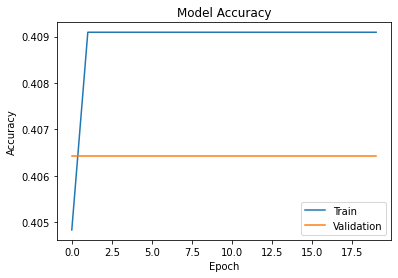

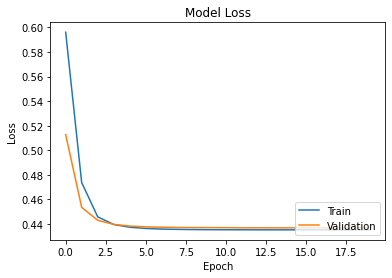

132/132 - 1s - loss: 0.4322 - accuracy: 0.4157 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.4322464168071747, 0.4157330095767975, 0.0, 0.0]

In [ ]:
import tensorflow as tf

word_size=1000
embed_size=128

"""### Building a Recurrent Neural Network"""

model=tf.keras.Sequential()

# Embedding Layer
model.add(tf.keras.layers.Embedding(word_size, embed_size, input_shape=(X_train.shape[1],)))

# LSTM Layer
model.add(tf.keras.layers.LSTM(units=64, activation='tanh'))

# Output Layer
model.add(tf.keras.layers.Dense(units=6, activation='sigmoid'))

model.summary()

"""#### Compiling the model"""

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

"""#### Training the model"""

import matplotlib.pyplot as plt
import numpy
history = model.fit(X_train, y_train, validation_split=0.30, epochs=20, batch_size=32, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=2)

CNN Implementation



dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


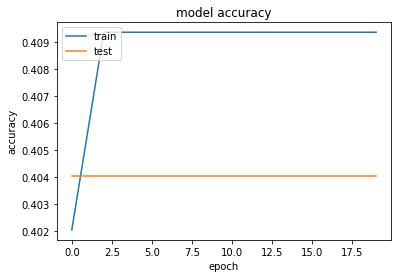

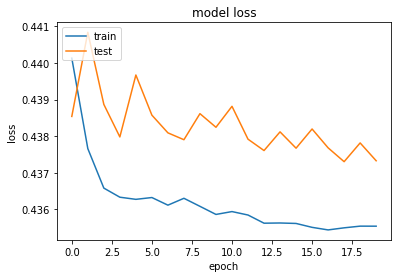

132/132 - 0s - loss: 0.4324 - accuracy: 0.4157 - precision: 0.0000e+00 - recall: 0.0000e+00


In [ ]:
#Imports for CNN
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

#Padding
max_words = 1000
top_words = 7000

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# Building the CNN Model
CNN = Sequential()      # initilaizing the Sequential nature for CNN model

# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
CNN.add(Embedding(top_words, 32, input_length=max_words))
CNN.add(Conv1D(32, 3, padding='same', activation='relu'))
CNN.add(MaxPooling1D())
CNN.add(Flatten())
CNN.add(Dense(250, activation='relu'))
CNN.add(Dense(6, activation='sigmoid'))
CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

#Running the model
history = CNN.fit(X_train, y_train, validation_split=0.20, epochs=20, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Getting score metrics from our model
scores = CNN.evaluate(X_test, y_test, verbose=2)

In this preproccesing variation, the corpus has been normalised. In addition to this, stemming has been applied using the PortStemmer method from the nltk package. This input is then fed into a RNN and a CNN as show below.

RNN Implementation

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 101, 128)          2560000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 2,609,798
Trainable params: 2,609,798
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


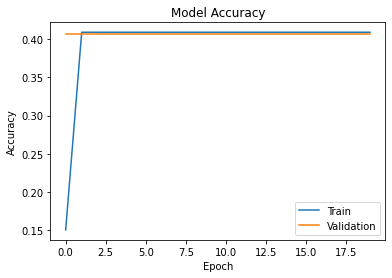

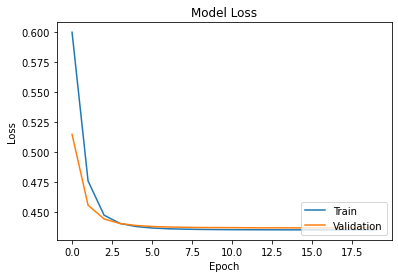

132/132 - 1s - loss: 0.4324 - accuracy: 0.4157 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.4323764443397522, 0.4157330095767975, 0.0, 0.0]

In [ ]:
import tensorflow as tf

word_size=20000
word_size

embed_size=128

"""### Building a Recurrent Neural Network"""

model=tf.keras.Sequential()

# Embedding Layer
model.add(tf.keras.layers.Embedding(word_size, embed_size, input_shape=(X_train.shape[1],)))

# LSTM Layer
model.add(tf.keras.layers.LSTM(units=64, activation='tanh'))

# Output Layer
model.add(tf.keras.layers.Dense(units=6, activation='sigmoid'))

model.summary()

"""#### Compiling the model"""

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

"""#### Training the model"""

import matplotlib.pyplot as plt
import numpy
history = model.fit(X_train, y_train, validation_split=0.30, epochs=20, batch_size=32, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=2)
scores


CNN Implementation

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


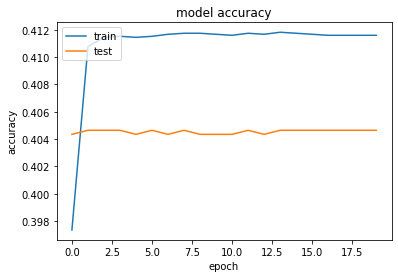

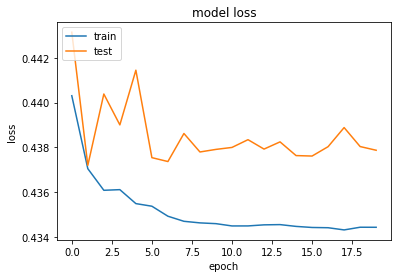

132/132 - 0s - loss: 0.4359 - accuracy: 0.4167 - precision: 0.4167 - recall: 9.6025e-04


In [ ]:
#Imports for CNN
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

#Padding
max_words = 1000
top_words = 7000

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# Building the CNN Model
CNN = Sequential()      # initilaizing the Sequential nature for CNN model

# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
CNN.add(Embedding(top_words, 32, input_length=max_words))
CNN.add(Conv1D(32, 3, padding='same', activation='relu'))
CNN.add(MaxPooling1D())
CNN.add(Flatten())
CNN.add(Dense(250, activation='relu'))
CNN.add(Dense(6, activation='sigmoid'))
CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

#Running the model
history = CNN.fit(X_train, y_train, validation_split=0.20, epochs=20, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Getting score metrics from our model
scores = CNN.evaluate(X_test, y_test, verbose=2)

In this variation, the corpus is normalised and lemmatisation is applied. The results are as follows.





Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 116, 128)          2560000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 390       
Total params: 2,609,798
Trainable params: 2,609,798
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


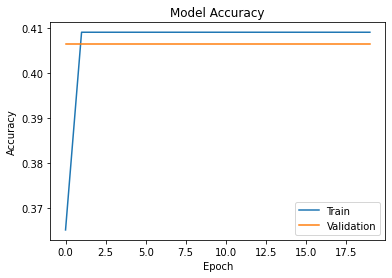

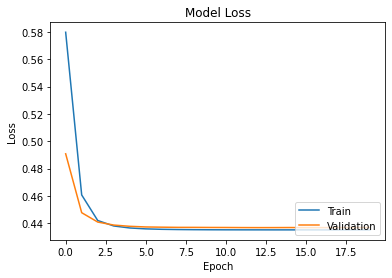

132/132 - 1s - loss: 0.4322 - accuracy: 0.4157 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.43221670389175415, 0.4157330095767975, 0.0, 0.0]

In [ ]:
import tensorflow as tf

word_size=20000
word_size

embed_size=128

"""### Building a Recurrent Neural Network"""

model=tf.keras.Sequential()

# Embedding Layer
model.add(tf.keras.layers.Embedding(word_size, embed_size, input_shape=(X_train.shape[1],)))

# LSTM Layer
model.add(tf.keras.layers.LSTM(units=64, activation='tanh'))

# Output Layer
model.add(tf.keras.layers.Dense(units=6, activation='sigmoid'))

model.summary()

"""#### Compiling the model"""

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

"""#### Training the model"""

import matplotlib.pyplot as plt
import numpy
history = model.fit(X_train, y_train, validation_split=0.30, epochs=20, batch_size=32, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=2)
scores

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


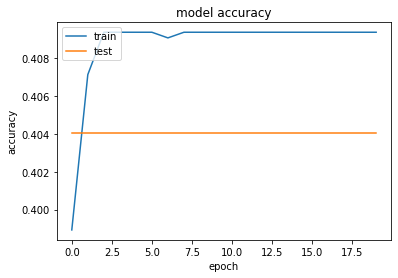

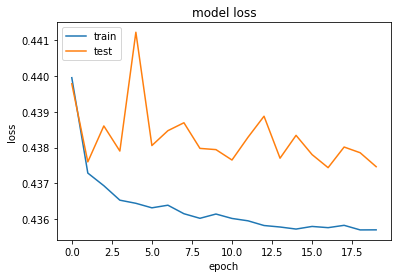

132/132 - 0s - loss: 0.4325 - accuracy: 0.4157 - precision: 0.0000e+00 - recall: 0.0000e+00


In [ ]:
#Imports for CNN
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

#Padding
max_words = 1000
top_words = 7000

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# Building the CNN Model
CNN = Sequential()      # initilaizing the Sequential nature for CNN model

# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
CNN.add(Embedding(top_words, 32, input_length=max_words))
CNN.add(Conv1D(32, 3, padding='same', activation='relu'))
CNN.add(MaxPooling1D())
CNN.add(Flatten())
CNN.add(Dense(250, activation='relu'))
CNN.add(Dense(6, activation='sigmoid'))
CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

#Running the model
history = CNN.fit(X_train, y_train, validation_split=0.20, epochs=20, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Getting score metrics from our model
scores = CNN.evaluate(X_test, y_test, verbose=2)

In this variation, the corpus is normalised as standard. However, this variation combines lemmatisation and stemming to analyse the effect. 

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 128)         2560000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 390       
Total params: 2,609,798
Trainable params: 2,609,798
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


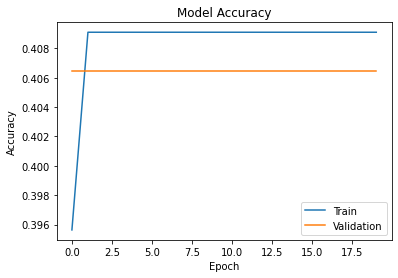

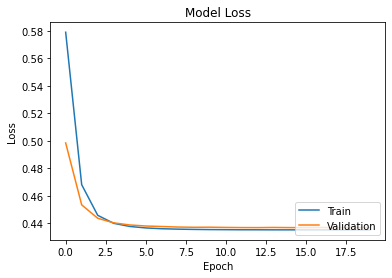

132/132 - 2s - loss: 0.4323 - accuracy: 0.4157 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.43230345845222473, 0.4157330095767975, 0.0, 0.0]

In [ ]:
import tensorflow as tf

word_size=20000
word_size

embed_size=128

"""### Building a Recurrent Neural Network"""

model=tf.keras.Sequential()

# Embedding Layer
model.add(tf.keras.layers.Embedding(word_size, embed_size, input_shape=(X_train.shape[1],)))

# LSTM Layer
model.add(tf.keras.layers.LSTM(units=64, activation='tanh'))

# Output Layer
model.add(tf.keras.layers.Dense(units=6, activation='sigmoid'))

model.summary()

"""#### Compiling the model"""

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

"""#### Training the model"""

import matplotlib.pyplot as plt
import numpy
history = model.fit(X_train, y_train, validation_split=0.30, epochs=20, batch_size=32, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=2)
scores

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


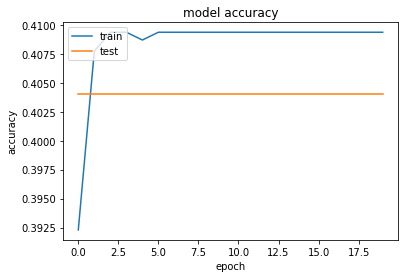

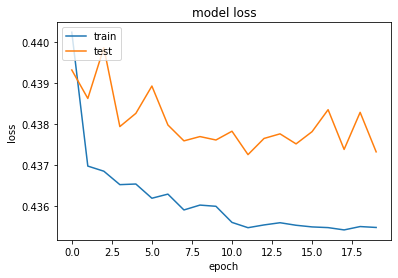

132/132 - 0s - loss: 0.4328 - accuracy: 0.4157 - precision: 0.0000e+00 - recall: 0.0000e+00


In [ ]:
#Imports for CNN
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

#Padding
max_words = 1000
top_words = 7000

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# Building the CNN Model
CNN = Sequential()      # initilaizing the Sequential nature for CNN model

# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
CNN.add(Embedding(top_words, 32, input_length=max_words))
CNN.add(Conv1D(32, 3, padding='same', activation='relu'))
CNN.add(MaxPooling1D())
CNN.add(Flatten())
CNN.add(Dense(250, activation='relu'))
CNN.add(Dense(6, activation='sigmoid'))
CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

#Running the model
history = CNN.fit(X_train, y_train, validation_split=0.20, epochs=20, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Getting score metrics from our model
scores = CNN.evaluate(X_test, y_test, verbose=2)

In this variation, the corpus is normalised as standard. Only bigrams are applied on the corpus which is done by passing (2,2) through the ngrams parameter in the TfidfVectorizer method. This input is then fed into a RNN and a CNN as follows.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 128)           2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 2,609,798
Trainable params: 2,609,798
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


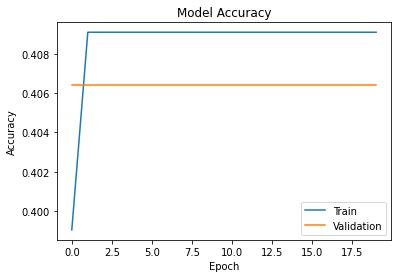

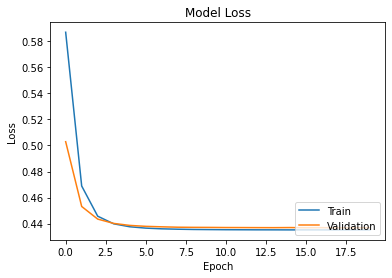

132/132 - 0s - loss: 0.4323 - accuracy: 0.4157 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.4322648346424103, 0.4157330095767975, 0.0, 0.0]

In [ ]:
import tensorflow as tf

word_size=20000
word_size

embed_size=128

"""### Building a Recurrent Neural Network"""

model=tf.keras.Sequential()

# Embedding Layer
model.add(tf.keras.layers.Embedding(word_size, embed_size, input_shape=(X_train.shape[1],)))

# LSTM Layer
model.add(tf.keras.layers.LSTM(units=64, activation='tanh'))

# Output Layer
model.add(tf.keras.layers.Dense(units=6, activation='sigmoid'))

model.summary()

"""#### Compiling the model"""

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

"""#### Training the model"""

import matplotlib.pyplot as plt
import numpy
history = model.fit(X_train, y_train, validation_split=0.30, epochs=20, batch_size=32, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=2)
scores

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


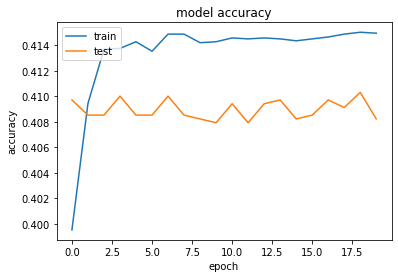

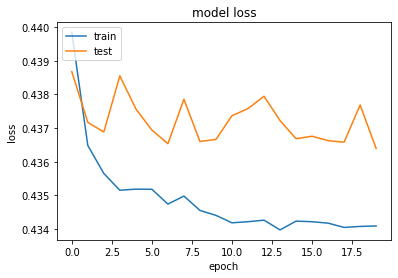

132/132 - 0s - loss: 0.4319 - accuracy: 0.4217 - precision: 0.5556 - recall: 0.0038


In [ ]:
#Imports for CNN
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

#Padding
max_words = 1000
top_words = 7000

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# Building the CNN Model
CNN = Sequential()      # initilaizing the Sequential nature for CNN model

# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
CNN.add(Embedding(top_words, 32, input_length=max_words))
CNN.add(Conv1D(32, 3, padding='same', activation='relu'))
CNN.add(MaxPooling1D())
CNN.add(Flatten())
CNN.add(Dense(250, activation='relu'))
CNN.add(Dense(6, activation='sigmoid'))
CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

#Running the model
history = CNN.fit(X_train, y_train, validation_split=0.20, epochs=20, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Getting score metrics from our model
scores = CNN.evaluate(X_test, y_test, verbose=2)

In this variation, the corpus is normalised as standard. Only trigrams are applied on the corpus which is done by passing (3,3) through the ngrams parameter in the TfidfVectorizer method. This input is then fed into a RNN and a CNN as follows.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 3, 128)            2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 2,609,798
Trainable params: 2,609,798
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


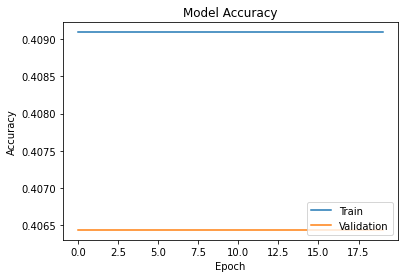

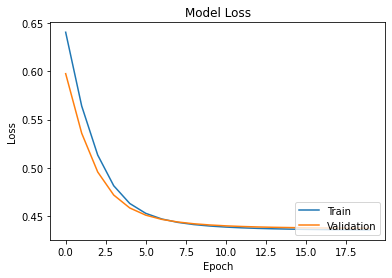

132/132 - 0s - loss: 0.4328 - accuracy: 0.4157 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.43279024958610535, 0.4157330095767975, 0.0, 0.0]

In [ ]:
import tensorflow as tf

word_size=20000
word_size

embed_size=128

"""### Building a Recurrent Neural Network"""

model=tf.keras.Sequential()

# Embedding Layer
model.add(tf.keras.layers.Embedding(word_size, embed_size, input_shape=(X_train.shape[1],)))

# LSTM Layer
model.add(tf.keras.layers.LSTM(units=64, activation='tanh'))

# Output Layer
model.add(tf.keras.layers.Dense(units=6, activation='sigmoid'))

model.summary()

"""#### Compiling the model"""

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

"""#### Training the model"""

import matplotlib.pyplot as plt
import numpy
history = model.fit(X_train, y_train, validation_split=0.30, epochs=20, batch_size=32, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=2)
scores

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


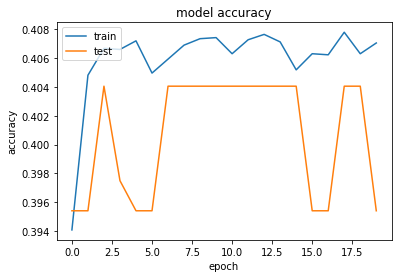

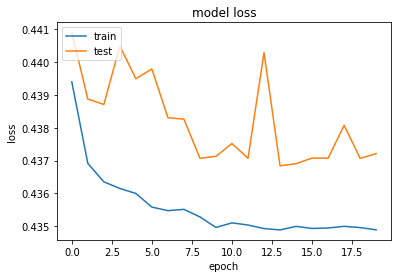

132/132 - 0s - loss: 0.4322 - accuracy: 0.3976 - precision: 0.5517 - recall: 0.0123


In [ ]:
#Imports for CNN
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

#Padding
max_words = 1000
top_words = 7000

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# Building the CNN Model
CNN = Sequential()      # initilaizing the Sequential nature for CNN model

# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
CNN.add(Embedding(top_words, 32, input_length=max_words))
CNN.add(Conv1D(32, 3, padding='same', activation='relu'))
CNN.add(MaxPooling1D())
CNN.add(Flatten())
CNN.add(Dense(250, activation='relu'))
CNN.add(Dense(6, activation='sigmoid'))
CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

#Running the model
history = CNN.fit(X_train, y_train, validation_split=0.20, epochs=20, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Getting score metrics from our model
scores = CNN.evaluate(X_test, y_test, verbose=2)

In this variation, the corpus is normalised as standard. Stopwords are removed using the english stopwords list from the nltk package. 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 59, 128)           128000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 177,798
Trainable params: 177,798
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


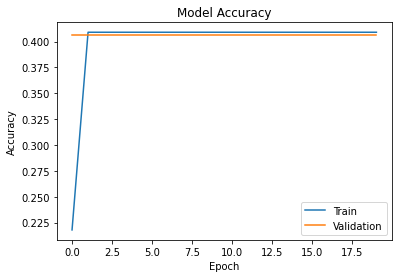

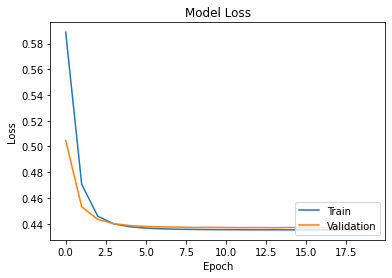

132/132 - 0s - loss: 0.4323 - accuracy: 0.4157 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.43227142095565796, 0.4157330095767975, 0.0, 0.0]

In [ ]:
import tensorflow as tf

word_size=1000
embed_size=128

"""### Building a Recurrent Neural Network"""

model=tf.keras.Sequential()

# Embedding Layer
model.add(tf.keras.layers.Embedding(word_size, embed_size, input_shape=(X_train.shape[1],)))

# LSTM Layer
model.add(tf.keras.layers.LSTM(units=64, activation='tanh'))

# Output Layer
model.add(tf.keras.layers.Dense(units=6, activation='sigmoid'))

model.summary()

"""#### Compiling the model"""

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

"""#### Training the model"""

import matplotlib.pyplot as plt
import numpy
history = model.fit(X_train, y_train, validation_split=0.30, epochs=20, batch_size=32, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=2)
scores

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


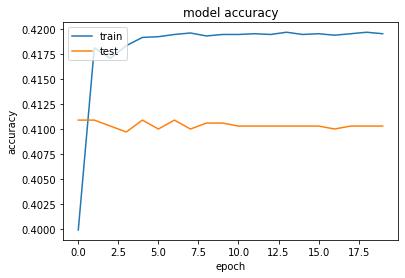

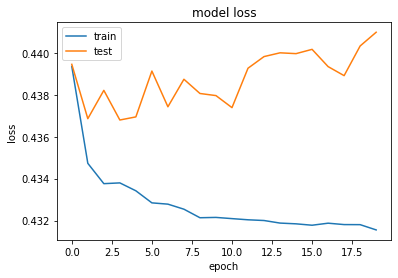

132/132 - 0s - loss: 0.4365 - accuracy: 0.4231 - precision: 0.6049 - recall: 0.0094


In [ ]:
#Imports for CNN
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

#Padding
max_words = 1000
top_words = 7000

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# Building the CNN Model
CNN = Sequential()      # initilaizing the Sequential nature for CNN model

# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
CNN.add(Embedding(top_words, 32, input_length=max_words))
CNN.add(Conv1D(32, 3, padding='same', activation='relu'))
CNN.add(MaxPooling1D())
CNN.add(Flatten())
CNN.add(Dense(250, activation='relu'))
CNN.add(Dense(6, activation='sigmoid'))
CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

#Running the model
history = CNN.fit(X_train, y_train, validation_split=0.20, epochs=20, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Getting score metrics from our model
scores = CNN.evaluate(X_test, y_test, verbose=2)

Normalisation stemming bigrams removed stopwords

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 76, 128)           128000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 177,798
Trainable params: 177,798
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


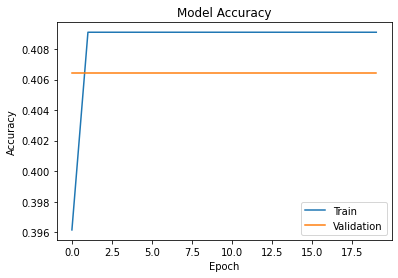

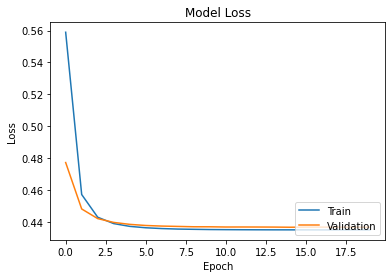

132/132 - 0s - loss: 0.4322 - accuracy: 0.4157 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.43224209547042847, 0.4157330095767975, 0.0, 0.0]

In [ ]:
import tensorflow as tf

word_size=1000
embed_size=128

"""### Building a Recurrent Neural Network"""

model=tf.keras.Sequential()

# Embedding Layer
model.add(tf.keras.layers.Embedding(word_size, embed_size, input_shape=(X_train.shape[1],)))

# LSTM Layer
model.add(tf.keras.layers.LSTM(units=64, activation='tanh'))

# Output Layer
model.add(tf.keras.layers.Dense(units=6, activation='sigmoid'))

model.summary()

"""#### Compiling the model"""

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

"""#### Training the model"""

import matplotlib.pyplot as plt
import numpy
history = model.fit(X_train, y_train, validation_split=0.30, epochs=20, batch_size=32, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=2)
scores

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


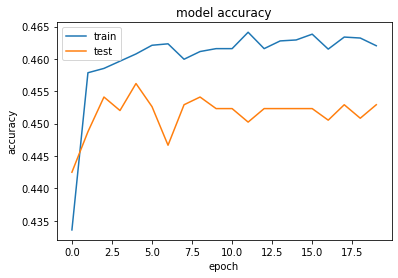

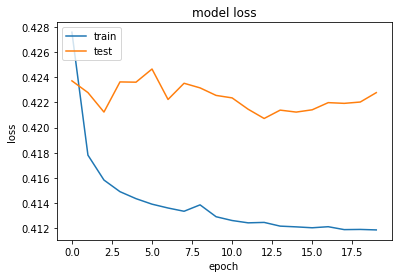

132/132 - 0s - loss: 0.4136 - accuracy: 0.4675 - precision: 0.6262 - recall: 0.1306


In [ ]:
#Imports for CNN
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

#Padding
max_words = 1000
top_words = 7000

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# Building the CNN Model
CNN = Sequential()      # initilaizing the Sequential nature for CNN model

# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
CNN.add(Embedding(top_words, 32, input_length=max_words))
CNN.add(Conv1D(32, 3, padding='same', activation='relu'))
CNN.add(MaxPooling1D())
CNN.add(Flatten())
CNN.add(Dense(250, activation='relu'))
CNN.add(Dense(6, activation='sigmoid'))
CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

#Running the model
history = CNN.fit(X_train, y_train, validation_split=0.20, epochs=20, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Getting score metrics from our model
scores = CNN.evaluate(X_test, y_test, verbose=2)

This variation involved changing the input to just the abstract. With only the abstract as the corpus, normalisation, stemming and bigrams were applied. Furthermore, all english stopwords were removed. After transformation with the TfidfVectorizer, these results were obtained. 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 75, 128)           128000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
Total params: 177,798
Trainable params: 177,798
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


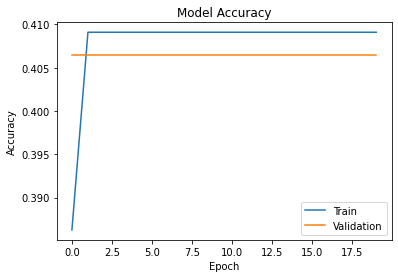

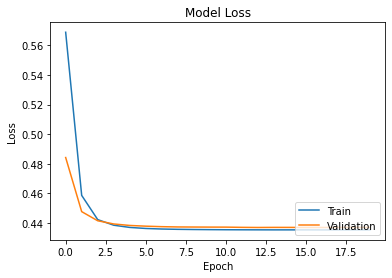

132/132 - 0s - loss: 0.4322 - accuracy: 0.4157 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.4322477877140045, 0.4157330095767975, 0.0, 0.0]

In [ ]:
import tensorflow as tf

word_size=1000
embed_size=128

"""### Building a Recurrent Neural Network"""

model=tf.keras.Sequential()

# Embedding Layer
model.add(tf.keras.layers.Embedding(word_size, embed_size, input_shape=(X_train.shape[1],)))

# LSTM Layer
model.add(tf.keras.layers.LSTM(units=64, activation='tanh'))

# Output Layer
model.add(tf.keras.layers.Dense(units=6, activation='sigmoid'))

model.summary()

"""#### Compiling the model"""

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

"""#### Training the model"""

import matplotlib.pyplot as plt
import numpy
history = model.fit(X_train, y_train, validation_split=0.30, epochs=20, batch_size=32, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=2)
scores

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


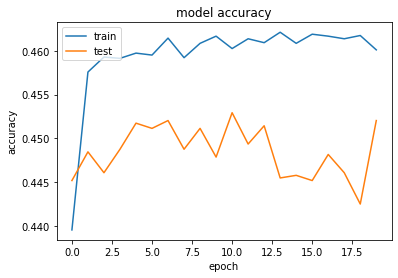

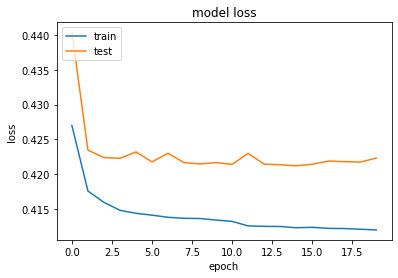

132/132 - 0s - loss: 0.4129 - accuracy: 0.4660 - precision: 0.6545 - recall: 0.1168


In [ ]:
#Imports for CNN
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

#Padding
max_words = 1000
top_words = 7000

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# Building the CNN Model
CNN = Sequential()      # initilaizing the Sequential nature for CNN model

# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
CNN.add(Embedding(top_words, 32, input_length=max_words))
CNN.add(Conv1D(32, 3, padding='same', activation='relu'))
CNN.add(MaxPooling1D())
CNN.add(Flatten())
CNN.add(Dense(250, activation='relu'))
CNN.add(Dense(6, activation='sigmoid'))
CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

#Running the model
history = CNN.fit(X_train, y_train, validation_split=0.20, epochs=20, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Getting score metrics from our model
scores = CNN.evaluate(X_test, y_test, verbose=2)

This variation used just the title as input. The title was normalised and all english stopwords were removed. In order to make the computation feasible, the dimensions must be reduced. The TfidfVectorizer has a 'min_df' parameter whereby the value of 0.001 was passed. Terms that have lower document frequency than 0.001 would be ignored and this resulted in an X.train shape of (16777, 1372). This required less RAM and was successfully executed as shown below.

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 1000, 128)         128000    
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 390       
Total params: 177,798
Trainable params: 177,798
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'categorical_accuracy', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_categorical_accuracy'])


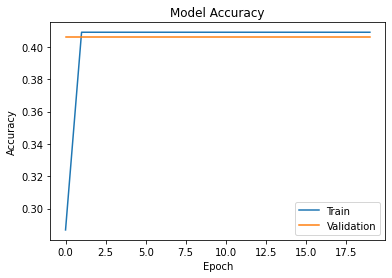

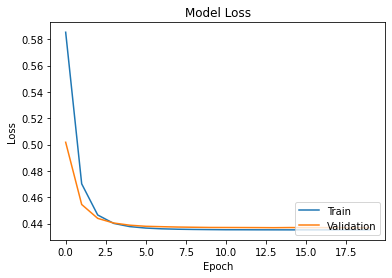

132/132 - 2s - loss: 0.4323 - accuracy: 0.4157 - precision: 0.0000e+00 - recall: 0.0000e+00 - categorical_accuracy: 0.4157


[0.43228039145469666, 0.4157330095767975, 0.0, 0.0, 0.4157330095767975]

In [ ]:
import tensorflow as tf
from keras import metrics

word_size=1000
embed_size=128

"""### Building a Recurrent Neural Network"""

model=tf.keras.Sequential()

# Embedding Layer
model.add(tf.keras.layers.Embedding(word_size, embed_size, input_shape=(X_train.shape[1],)))

# LSTM Layer
model.add(tf.keras.layers.LSTM(units=64, activation='tanh'))

# Output Layer
model.add(tf.keras.layers.Dense(units=6, activation='sigmoid'))

model.summary()

"""#### Compiling the model"""

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.categorical_accuracy])

"""#### Training the model"""

import matplotlib.pyplot as plt
import numpy
history = model.fit(X_train, y_train, validation_split=0.30, epochs=20, batch_size=32, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=2)
scores

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


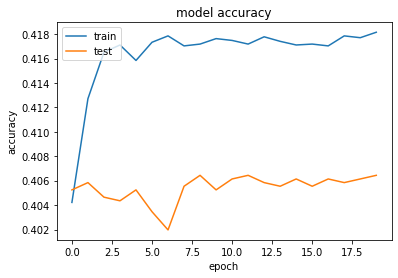

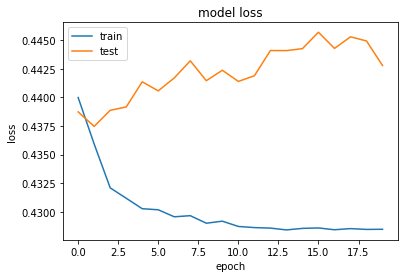

132/132 - 0s - loss: 0.4386 - accuracy: 0.4195 - precision: 0.5217 - recall: 0.0069


In [ ]:
#Imports for CNN
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

#Padding
max_words = 1000
top_words = 7000

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# Building the CNN Model
CNN = Sequential()      # initilaizing the Sequential nature for CNN model

# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
CNN.add(Embedding(top_words, 32, input_length=max_words))
CNN.add(Conv1D(32, 3, padding='same', activation='relu'))
CNN.add(MaxPooling1D())
CNN.add(Flatten())
CNN.add(Dense(250, activation='relu'))
CNN.add(Dense(6, activation='sigmoid'))
CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

#Running the model
history = CNN.fit(X_train, y_train, validation_split=0.20, epochs=20, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Getting score metrics from our model
scores = CNN.evaluate(X_test, y_test, verbose=2)

**Pre-processing conclusions**

This experiment has gone through many preprocessing variations. 

## Experiment 2- Text featurisation/ transformation




This experiment involves varying the parameters in the TfidfVectorizer. There is another method of converting raw documents into TF-IDF features which uses the CountVectorizer and TfidfTransformer classes. However, these two methods are equivalent therefore no experiments will be carried out on the two methods as they would yield similar results. 

min df 0.1

In [ ]:
beta = 2 # arbitrarily setting beta to 2. You can set it to any value you choose to
threshold = 0.2 # arbitrarily setting beta to 0.2. You can set it to any value you choose to

def multi_label_fbeta(ytrue , ypred, beta=beta, average='samples', threshold=threshold, epsilon=1e-7, \
                      sample_weight=None):
    # epsilon is set to avoid division by zero error
    beta_squared = beta**2

    # casting ytrue and ypred as floats
    ytrue = tf.cast(ytrue, tf.float32)
    
    # making ypred one hot encoded 
    ypred = tf.cast(tf.greater_equal(tf.cast(ypred, tf.float32), tf.constant(threshold)), tf.float32)
    
    if average == 'samples':
        tp = tf.reduce_sum(ytrue * ypred, axis=-1) # calculating true positives
        predicted_positive = tf.reduce_sum(ypred, axis=-1) # calculating predicted positives
        actual_positive = tf.reduce_sum(ytrue, axis=-1) # calculating actual positives
    
    else: # either any of 'macro', 'weighted' and 'raw'
        tp = tf.reduce_sum(ytrue * ypred, axis=0) # calculating true positives
        predicted_positive = tf.reduce_sum(ypred, axis=0) # calculating predicted positives
        actual_positive = tf.reduce_sum(ytrue, axis=0) # calculating actual positives
    
    # calculating precision and recall
    precision = tp/(predicted_positive+epsilon)
    recall = tp/(actual_positive+epsilon)

    # finding fbeta
    fb = (1+beta_squared)*precision*recall / (beta_squared*precision + recall + epsilon)

    if average == 'weighted':
        supports = tf.reduce_sum(ytrue, axis=0)
        return tf.reduce_sum(fb*supports / tf.reduce_sum(supports))

    elif average == 'raw':
        return fb
    
    elif average == 'samples' and sample_weight is not None:
        return tf.reduce_sum(fb*sample_weight)
    
    return tf.reduce_mean(fb) # then it is either 'macro' or 'samples' (without sample weight)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 1000, 128)         128000    
_________________________________________________________________
lstm_20 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_30 (Dense)             (None, 6)                 390       
Total params: 177,798
Trainable params: 177,798
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


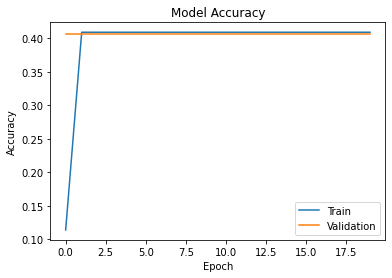

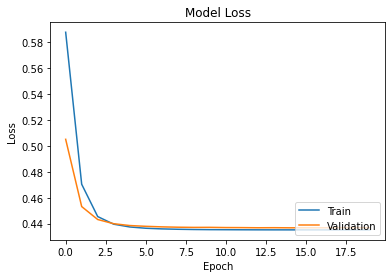

132/132 - 2s - loss: 0.4323 - accuracy: 0.4157
[0.4323188066482544, 0.4157330095767975]
f1_score of prediction using multi_label_fbeta is 0.6513954401016235


In [ ]:
import tensorflow as tf

word_size=1000
embed_size=128

"""### Building a Recurrent Neural Network"""

model=tf.keras.Sequential()

# Embedding Layer
model.add(tf.keras.layers.Embedding(word_size, embed_size, input_shape=(X_train.shape[1],)))

# LSTM Layer
model.add(tf.keras.layers.LSTM(units=64, activation='tanh'))

# Output Layer
model.add(tf.keras.layers.Dense(units=6, activation='sigmoid'))

model.summary()

"""#### Compiling the model"""

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

"""#### Training the model"""

import matplotlib.pyplot as plt
import numpy
history = model.fit(X_train, y_train, validation_split=0.30, epochs=20, batch_size=32, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=2)
print(scores)

y_pred= model.predict(X_test)
print('f1_score of prediction using multi_label_fbeta is {}'.format(multi_label_fbeta(y_test, y_pred)))

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


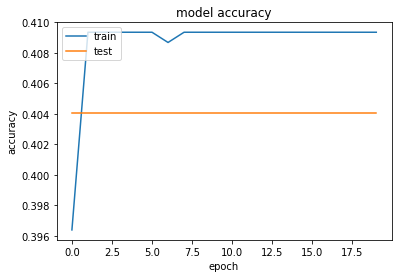

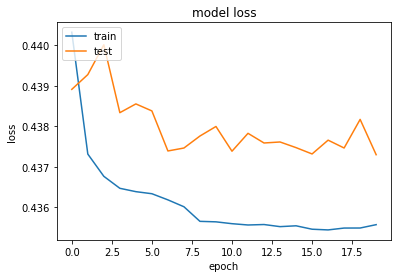

132/132 - 0s - loss: 0.4325 - accuracy: 0.4157 - precision: 0.0000e+00 - recall: 0.0000e+00


In [ ]:
#Imports for CNN
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

#Padding
max_words = 1000
top_words = 7000

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# Building the CNN Model
CNN = Sequential()      # initilaizing the Sequential nature for CNN model

# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
CNN.add(Embedding(top_words, 32, input_length=max_words))
CNN.add(Conv1D(32, 3, padding='same', activation='relu'))
CNN.add(MaxPooling1D())
CNN.add(Flatten())
CNN.add(Dense(250, activation='relu'))
CNN.add(Dense(6, activation='sigmoid'))

CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])



#Running the model
history = CNN.fit(X_train, y_train, validation_split=0.20, epochs=20, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Getting score metrics from our model
scores = CNN.evaluate(X_test, y_test, verbose=2)


0.2 min df

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 16, 128)           2560000   
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_21 (Dense)             (None, 6)                 390       
Total params: 2,609,798
Trainable params: 2,609,798
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


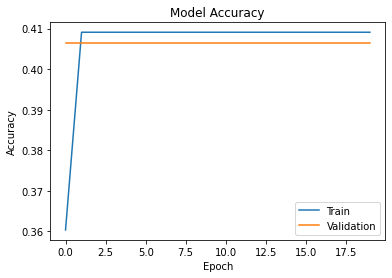

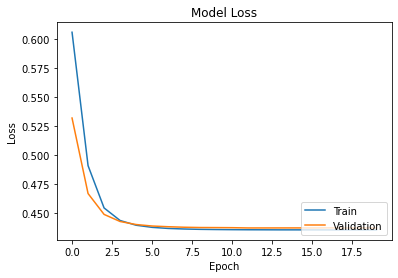

132/132 - 0s - loss: 0.4323 - accuracy: 0.4157 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.43226420879364014, 0.4157330095767975, 0.0, 0.0]

In [ ]:
import tensorflow as tf

word_size=20000
word_size

embed_size=128

"""### Building a Recurrent Neural Network"""

model=tf.keras.Sequential()

# Embedding Layer
model.add(tf.keras.layers.Embedding(word_size, embed_size, input_shape=(X_train.shape[1],)))

# LSTM Layer
model.add(tf.keras.layers.LSTM(units=64, activation='tanh'))

# Output Layer
model.add(tf.keras.layers.Dense(units=6, activation='sigmoid'))

model.summary()

"""#### Compiling the model"""

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

"""#### Training the model"""

import matplotlib.pyplot as plt
import numpy
history = model.fit(X_train, y_train, validation_split=0.30, epochs=20, batch_size=32, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=2)
scores

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


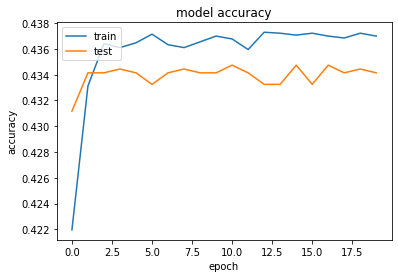

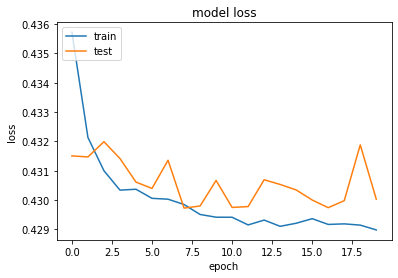

132/132 - 0s - loss: 0.4256 - accuracy: 0.4446 - precision: 0.6100 - recall: 0.0234


In [ ]:
#Imports for CNN
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

#Padding
max_words = 1000
top_words = 7000

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# Building the CNN Model
CNN = Sequential()      # initilaizing the Sequential nature for CNN model

# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
CNN.add(Embedding(top_words, 32, input_length=max_words))
CNN.add(Conv1D(32, 3, padding='same', activation='relu'))
CNN.add(MaxPooling1D())
CNN.add(Flatten())
CNN.add(Dense(250, activation='relu'))
CNN.add(Dense(6, activation='sigmoid'))
CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

#Running the model
history = CNN.fit(X_train, y_train, validation_split=0.20, epochs=20, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Getting score metrics from our model
scores = CNN.evaluate(X_test, y_test, verbose=2)

min df 0.3

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 4, 128)            2560000   
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_24 (Dense)             (None, 6)                 390       
Total params: 2,609,798
Trainable params: 2,609,798
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


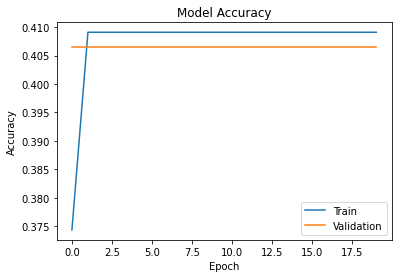

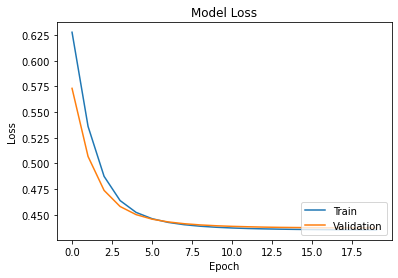

132/132 - 0s - loss: 0.4325 - accuracy: 0.4157 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.43245354294776917, 0.4157330095767975, 0.0, 0.0]

In [ ]:
import tensorflow as tf

word_size=20000
word_size

embed_size=128

"""### Building a Recurrent Neural Network"""

model=tf.keras.Sequential()

# Embedding Layer
model.add(tf.keras.layers.Embedding(word_size, embed_size, input_shape=(X_train.shape[1],)))

# LSTM Layer
model.add(tf.keras.layers.LSTM(units=64, activation='tanh'))

# Output Layer
model.add(tf.keras.layers.Dense(units=6, activation='sigmoid'))

model.summary()

"""#### Compiling the model"""

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

"""#### Training the model"""

import matplotlib.pyplot as plt
import numpy
history = model.fit(X_train, y_train, validation_split=0.30, epochs=20, batch_size=32, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=2)
scores

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


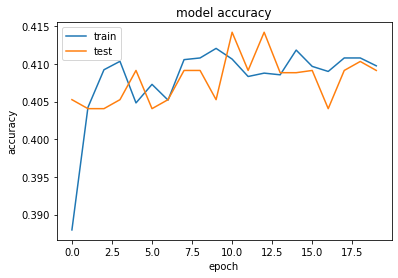

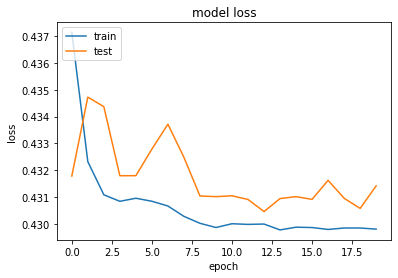

132/132 - 0s - loss: 0.4283 - accuracy: 0.4181 - precision: 0.5043 - recall: 0.0340


In [ ]:
#Imports for CNN
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

#Padding
max_words = 1000
top_words = 7000

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# Building the CNN Model
CNN = Sequential()      # initilaizing the Sequential nature for CNN model

# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
CNN.add(Embedding(top_words, 32, input_length=max_words))
CNN.add(Conv1D(32, 3, padding='same', activation='relu'))
CNN.add(MaxPooling1D())
CNN.add(Flatten())
CNN.add(Dense(250, activation='relu'))
CNN.add(Dense(6, activation='sigmoid'))
CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

#Running the model
history = CNN.fit(X_train, y_train, validation_split=0.20, epochs=20, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Getting score metrics from our model
scores = CNN.evaluate(X_test, y_test, verbose=2)

0.05

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 217, 128)          2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 2,609,798
Trainable params: 2,609,798
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


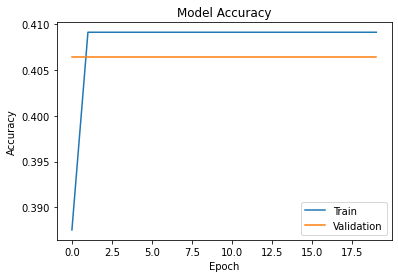

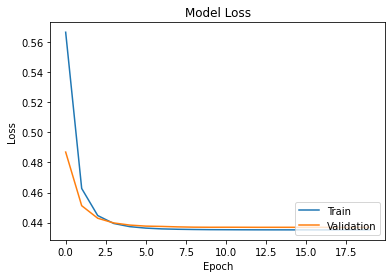

132/132 - 1s - loss: 0.4323 - accuracy: 0.4157 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.4322764277458191, 0.4157330095767975, 0.0, 0.0]

In [ ]:
import tensorflow as tf

word_size=20000
word_size

embed_size=128

"""### Building a Recurrent Neural Network"""

model=tf.keras.Sequential()

# Embedding Layer
model.add(tf.keras.layers.Embedding(word_size, embed_size, input_shape=(X_train.shape[1],)))

# LSTM Layer
model.add(tf.keras.layers.LSTM(units=64, activation='tanh'))

# Output Layer
model.add(tf.keras.layers.Dense(units=6, activation='sigmoid'))

model.summary()

"""#### Compiling the model"""

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

"""#### Training the model"""

import matplotlib.pyplot as plt
import numpy
history = model.fit(X_train, y_train, validation_split=0.30, epochs=20, batch_size=32, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=2)
scores

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


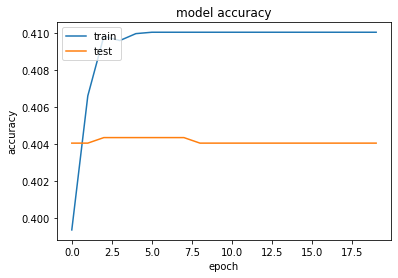

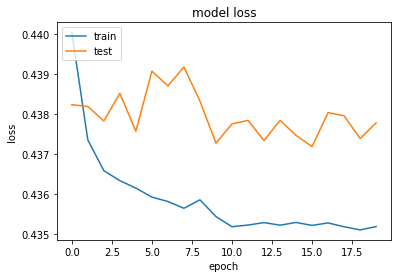

132/132 - 0s - loss: 0.4324 - accuracy: 0.4162 - precision: 0.0000e+00 - recall: 0.0000e+00


In [ ]:
#Imports for CNN
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

#Padding
max_words = 1000
top_words = 7000

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# Building the CNN Model
CNN = Sequential()      # initilaizing the Sequential nature for CNN model

# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
CNN.add(Embedding(top_words, 32, input_length=max_words))
CNN.add(Conv1D(32, 3, padding='same', activation='relu'))
CNN.add(MaxPooling1D())
CNN.add(Flatten())
CNN.add(Dense(250, activation='relu'))
CNN.add(Dense(6, activation='sigmoid'))
CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

#Running the model
history = CNN.fit(X_train, y_train, validation_split=0.20, epochs=20, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Getting score metrics from our model
scores = CNN.evaluate(X_test, y_test, verbose=2)

0.01

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 128)         127872    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
Total params: 177,670
Trainable params: 177,670
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


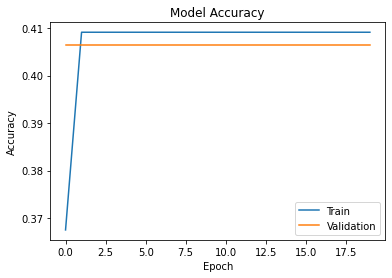

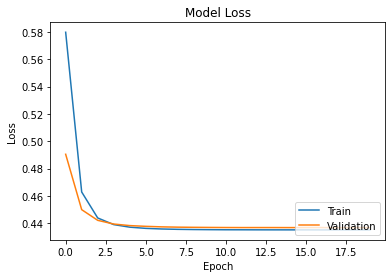

132/132 - 2s - loss: 0.4323 - accuracy: 0.4157 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.43228402733802795, 0.4157330095767975, 0.0, 0.0]

In [ ]:
import tensorflow as tf

word_size=999
embed_size=128

"""### Building a Recurrent Neural Network"""

model=tf.keras.Sequential()

# Embedding Layer
model.add(tf.keras.layers.Embedding(word_size, embed_size, input_shape=(X_train.shape[1],)))

# LSTM Layer
model.add(tf.keras.layers.LSTM(units=64, activation='tanh'))

# Output Layer
model.add(tf.keras.layers.Dense(units=6, activation='sigmoid'))

model.summary()

"""#### Compiling the model"""

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

"""#### Training the model"""

import matplotlib.pyplot as plt
import numpy
history = model.fit(X_train, y_train, validation_split=0.30, epochs=20, batch_size=32, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Getting score metrics from our model
scores = model.evaluate(X_test, y_test, verbose=2)
scores

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


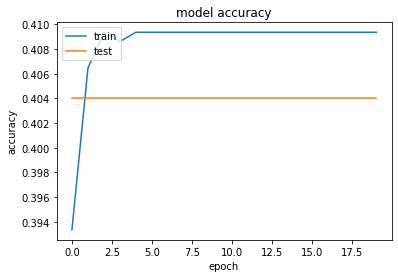

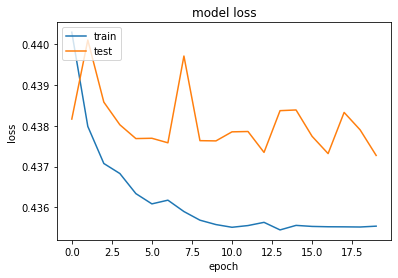

132/132 - 0s - loss: 0.4326 - accuracy: 0.4157 - precision: 0.0000e+00 - recall: 0.0000e+00


In [ ]:
#Imports for CNN
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

#Padding
max_words = 1000
top_words = 7000

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# Building the CNN Model
CNN = Sequential()      # initilaizing the Sequential nature for CNN model

# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
CNN.add(Embedding(top_words, 32, input_length=max_words))
CNN.add(Conv1D(32, 3, padding='same', activation='relu'))
CNN.add(MaxPooling1D())
CNN.add(Flatten())
CNN.add(Dense(250, activation='relu'))
CNN.add(Dense(6, activation='sigmoid'))
CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

#Running the model
history = CNN.fit(X_train, y_train, validation_split=0.20, epochs=20, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Getting score metrics from our model
scores = CNN.evaluate(X_test, y_test, verbose=2)

## Experiment 3- Loss functions and optimisers

This is a multi-class and multi-label task. In other words, a research paper can be many different subjects. Thus a sigmoid activation function is used the final layer. The Sigmoid function converts each score of the final node between 0 to 1 independent of what the other scores might be. The binary crossentropy loss is used with the sigmoid function.